# Color Cell IDs

Given an Excel spreadsheet indicating the cell type of each ID, a plot will be made of the tissue cross-section, where each cell type will have a different color.

The Excel spreadsheet must have one cell-type per column. Then each column will indicate the IDs to color. It is ok if different columns have different number of IDs. The column must also indicate the color corresponding to the cell type.

The background in the output figure will be white. Cells whose IDs was not indicated in any column will be colored gray.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import tifffile as tf
import os

from scipy import ndimage

In [2]:
sample = 'B2'

wsrc = os.pardir + os.sep + 'cell_dams' + os.sep
csrc = os.pardir + os.sep + 'data' + os.sep
ksrc = os.pardir + os.sep + 'kde' + os.sep + sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='orig_cellID')

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
css = ndimage.find_objects(label)

In [3]:
xlsxname = 'RootCellTypeAssignment'
#xlsxname = 'D2.Cell.I.D.Assignments'

data = pd.read_excel(csrc + xlsxname + '.xlsx', sheet_name=sample).drop(labels=0, axis=0)
dcolors = [ '#' + data.columns[i][:-1].split('(')[1] for i in range(data.shape[1]) ]
print(dcolors)
cmap = mpl.colors.ListedColormap(['#bbbbbb', '#ffffff'] + dcolors)
print(data.shape)
data.head()

['#09C8F7', '#AB24B1', '#F4C8A1', '#FB8E01', '#BB4918', '#BE9146']
(43, 6)


,Epidermis (09C8F7),Cortex (AB24B1),Cambium (F4C8A1),Pericycle (FB8E01),Xylem (BB4918),Phloem (BE9146)
1,400.0,23.0,310.0,86,452.0,136.0
2,1110.0,26.0,345.0,88,719.0,148.0
3,1122.0,32.0,883.0,120,843.0,171.0
4,NaN,36.0,895.0,141,334.0,204.0
5,NaN,54.0,253.0,149,881.0,256.0


In [4]:
wall = np.zeros(wallshape, dtype=int)
for i in range(data.shape[1]):
    idx =  data.loc[~pd.isna(data.iloc[:,i])].iloc[:,i].values.astype(int)
    
    for val in metacell.loc[list(set(idx) & set(metacell.index)) , 'ndimage_cellID'].values:
        wall[ css[val-1] ][label[css[val-1]] == val] = i+2
wall[label == 1] = 1

../cell_dams/B2_RootCellTypeAssignment.png


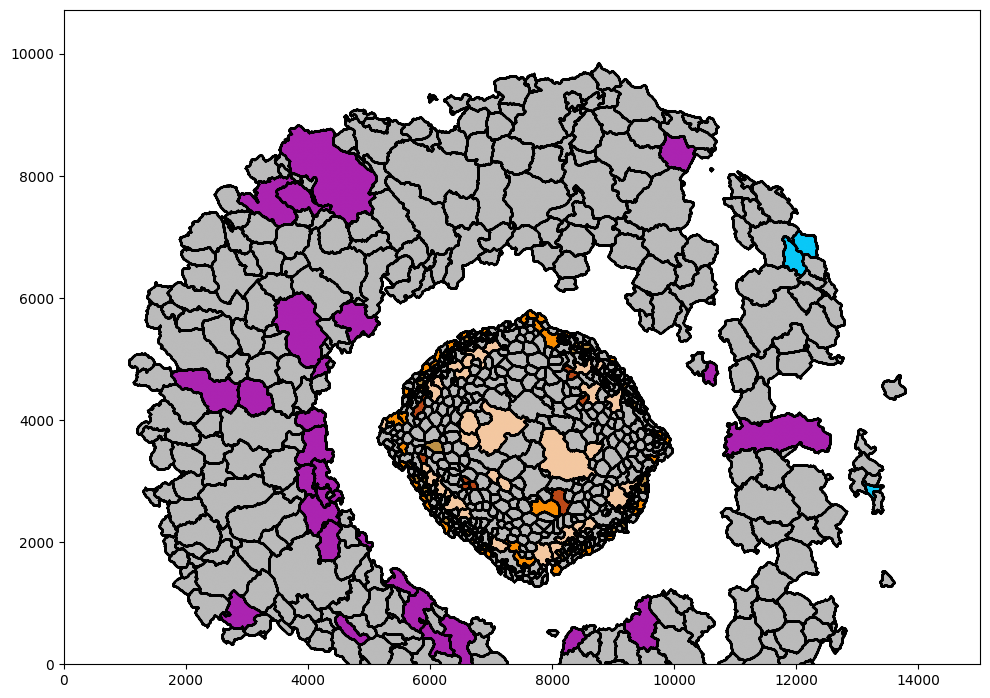

In [6]:
fs = 20
fig, ax = plt.subplots(1,1,figsize=(10,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(wall, cmap=cmap, zorder=1, origin='lower')
ax[0].scatter(wcoords[1], wcoords[0], marker='.', s=0.1, c='k', zorder=2)

ax[0].set_aspect('equal')
fig.tight_layout();

filename = wsrc + sample + '_' + xlsxname + '.png'
print(filename)
plt.savefig(filename, dpi=200, format='png', bbox_inches='tight')